<div style="width:image width px; font-size:75%; text-align:right;">
    <img src="img/pexels-brandon-montrone-1179229.jpg" width="width" height="height" style="padding-bottom:0.2em;" />
    <figcaption>Photo by Brandon Montrone on Pexels</figcaption>
</div>

# Machine Learning 1

**Applied Programming - Summer term 2023 - FOM Hochschule für Oekonomie und Management - Cologne**

**Lecture 07 - May 17, 2023**

*Dennis Gluesenkamp*

## Table of contents
* [Dataset retrieval](#dataretrieval)
* [Preprocessing](#preprocessing)
    * [Imputation](#preprocessing_imputation)
    * [Categorical encoding](#preprocessing_encoding)
    * [Train-test-split](#preprocessing_traintestsplit)
    * [Scaling](#preprocessing_scaling)
* [Supporting techniques for modelling](#support)
    * [Cross validation](#support_cv)
    * [Grid search](#support_grid)
    * [Combined application in Scikit-learn](#support_combined)
* [Classification](#classification)
    * [Decision tree classifier](#classification_dt)
    * [Random forest classifier](#classification_rf)
    * [Homework](#classification_homework)
* [References](#references)

## Dataset retrieval<a class="anchor" id="dataretrieval"></a>
For the following work on machine learning algorithms, we need some data sets. These are generated or provided in a first step.

In [2]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.datasets import make_regression
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_diabetes

%matplotlib inline

np.random.seed(42)

In [3]:
# Artificial classification problem:
X_c, y_c = make_classification(n_samples            = 1000,
                               n_features           = 10,
                               n_redundant          = 2,
                               n_informative        = 5,
                               n_classes            = 3,
                               n_clusters_per_class = 3,
                               flip_y               = 0.05,
                               shift                = None,
                               random_state         = 42)

# Artificial regression problem:
X_r, y_r = make_regression(n_samples     = 1000,
                           n_features    = 10,
                           n_informative = 5,
                           noise         = 0.05,
                           random_state  = 42)

# Scikit-learn toy dataset for classification:
X_b, y_b = load_breast_cancer(return_X_y = True)

# Scikit-learn toy dataset for regression:
X_d, y_d = load_diabetes(return_X_y = True)

# Kaggle dataset for classification:
# Rain in Australia - Predict next-day rain in Australia
# https://www.kaggle.com/jsphyg/weather-dataset-rattle-package
df_w = pd.read_csv('dat/weatherAUS.csv')

# Kaggle dataset for regression:
# Medical Cost Personal Datasets - Insurance Forecast by using Linear Regression
# https://www.kaggle.com/mirichoi0218/insurance
df_i = pd.read_csv('dat/insurance.csv')

## Preprocessing<a class="anchor" id="preprocessing"></a>
Every machine learning model creation starts with data preprocessing, where the raw data is converted into a format suitable for the later algorithm(s). This is necessary because real-world data is very often incomplete, inconsistent, unclean, or even contains errors. These shortcomings, which can hinder or prevent the creation of an algorithm, can be completely or partially eliminated by data preprocessing. Thus, preprocessing is a fundamental step that makes machine learning possible.
Preprocessing is composed of different steps, each with different objectives:

* The so-called **imputation** addresses existing missing values and replaces them, if possible, with suitable substitutions.
* Categorical variables are converted into a numerical value during **encoding**, which can be processed by the algorithm in contrast to the categories.
* To test the performance of the model, the dataset is split into two sets during the **training-test-split**.
* Some algorithms require numerical input in a certain scale range, which is produced by **scaling**.

Not every step is required for every algorithm or useful in every approach. This must be examined on a case-by-case basis.

### Imputation<a class="anchor" id="preprocessing_imputation"></a>
The artificially created data sets do not contain any missing values by definition respectively by construction. For the other data sets this has to be checked.

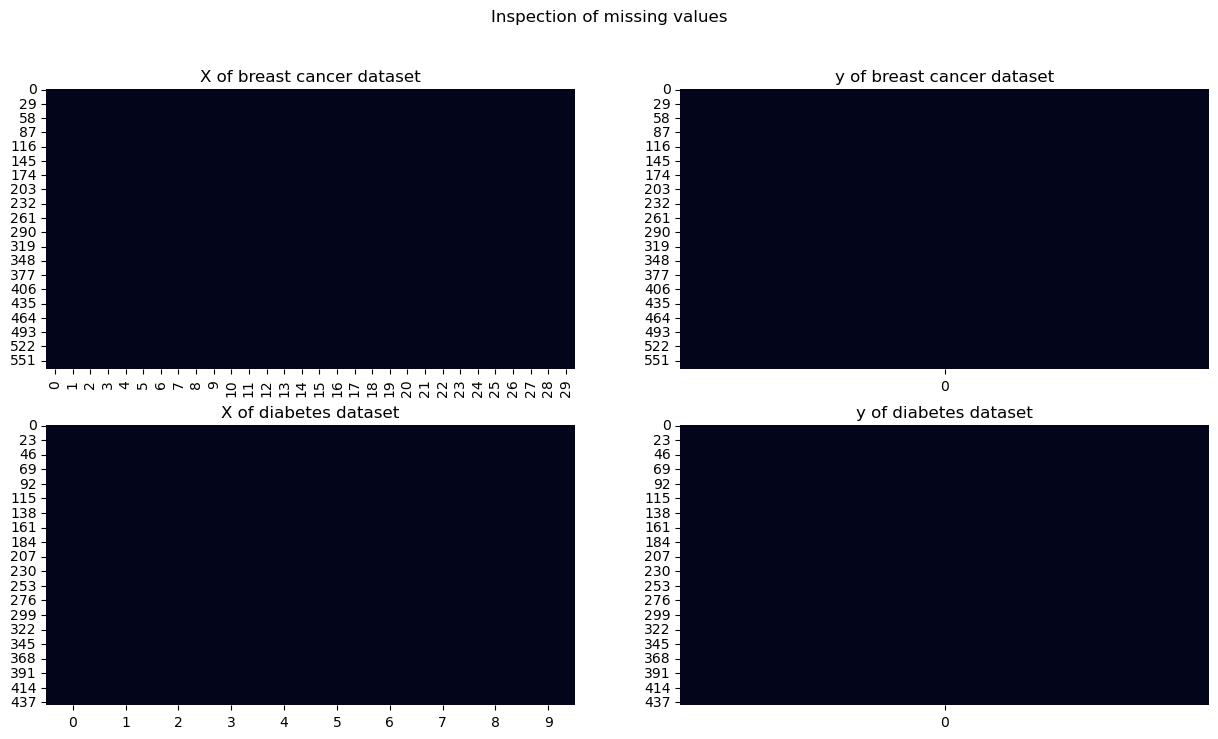

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8), sharey = False)
fig.suptitle('Inspection of missing values')

sns.heatmap(ax = axes[0, 0], data = pd.DataFrame(X_b).isnull(), cbar = False)
axes[0, 0].set_title('X of breast cancer dataset')
sns.heatmap(ax = axes[0, 1], data = pd.DataFrame(y_b).isnull(), cbar = False)
axes[0, 1].set_title('y of breast cancer dataset')

sns.heatmap(ax = axes[1, 0], data = pd.DataFrame(X_d).isnull(), cbar = False)
axes[1, 0].set_title('X of diabetes dataset')
sns.heatmap(ax = axes[1, 1], data = pd.DataFrame(y_d).isnull(), cbar = False)
axes[1, 1].set_title('y of diabetes dataset')

plt.draw()

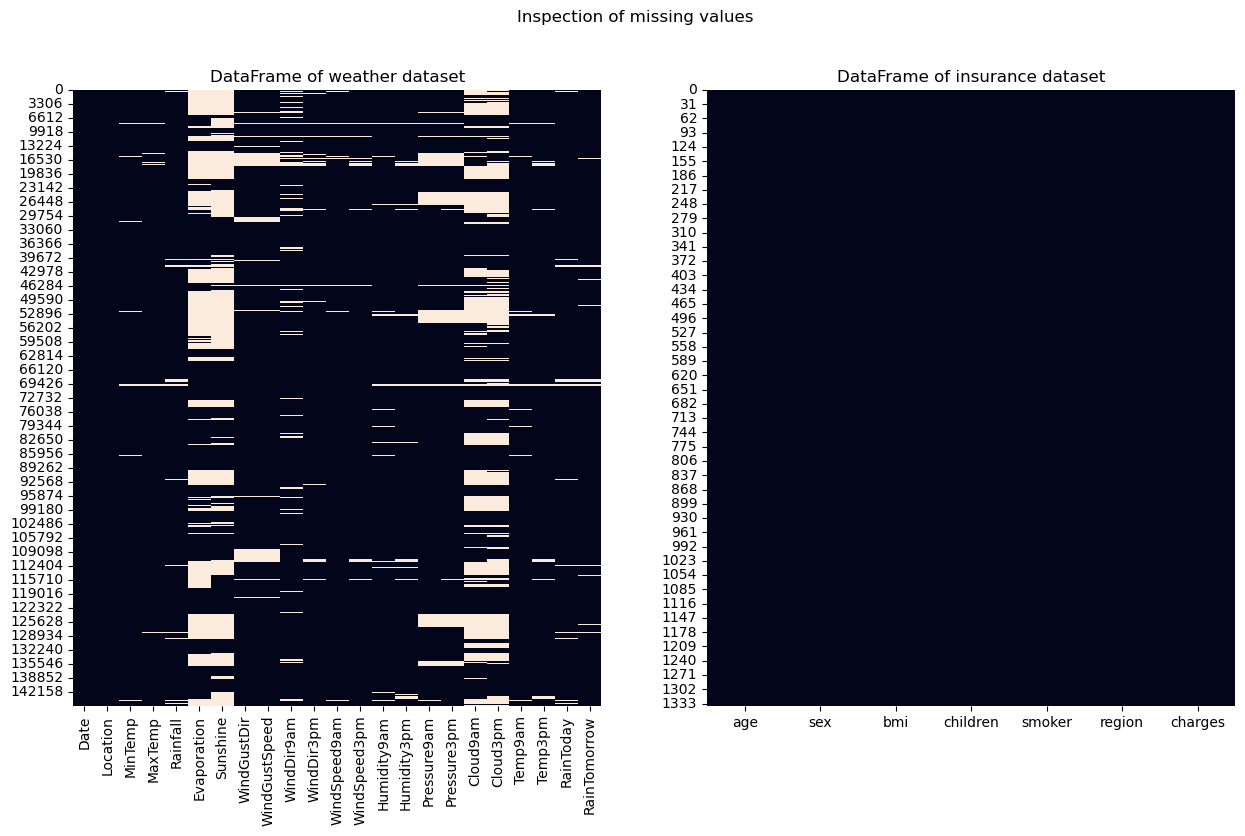

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey = False)
fig.suptitle('Inspection of missing values')

sns.heatmap(ax = axes[0], data = df_w.isnull(), cbar = False)
axes[0].set_title('DataFrame of weather dataset')

sns.heatmap(ax = axes[1], data = df_i.isnull(), cbar = False)
axes[1].set_title('DataFrame of insurance dataset')

plt.draw()

In [6]:
df_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

There are quite a lot of missing values in the Australian weather dataset. This includes several attributes in varying degrees. We consider which imputation strategy to use on a case-by-case basis. From Scikit-learn, the ``SimpleImputer`` class is available for this purpose, which includes ``strategy`` as a parameter:
* ``mean``: Replace missing values with mean of the affected column, which has to be numeric.
* ``median``: Replace missing values with median of the affected column, which has to be numeric.
* ``most_frequent``: Replace missing with the most frequent value of the column (smallest value if there is more than one).
* ``constant``: Replace missing values with given ``fill_value``, which is also a parameter of the class.

However, the ``fillna()`` method from pandas can also be used here and is particularly useful for different procedures within a data set.

First, the numerical attributes are processed, for which a substitution based on statistical measures would be possible. Here we decide to replace with the mean value. These include:
* ``MinTemp``
* ``MaxTemp``
* ``Rainfall``
* ``WindGustSpeed``
* ``WindSpeed9am``
* ``WindSpeed3pm``
* ``Humidity9am``
* ``Humidity3pm``
* ``Pressure9am``
* ``Pressure3pm``
* ``Temp9am``
* ``Temp3pm``

*Comment: Whether a replacement with the mean value really makes sense should also be checked, for example, by looking at the distribution of the attribute. However, the scope at this point should not be exceeded by this exploration, which is necessary in reality, but too small-scale for the purposes of this lecture.*

In addition, there are four other numeric attributes, but they have a substantially higher proportion of missing values in comparison. The high percentage of almost 50% is a considerable obstacle. One possible strategy may be to exclude such sparsely populated attributes. Since we also want to include this approach here, the following four attributes are dropped without further examination.
* ``Evaporation``
* ``Sunshine``
* ``Cloud9am``
* ``Cloud3pm``

Finally, the categorical attributes are left. For the wind directions, a meaningful substitution is difficult. For this reason, the missing values are replaced here with a new category M. This also preserves the information about the missing, but the algorithm can be trained. This affects namely the following attributes:
* ``WindGustDir``
* ``WindDir9am``
* ``WindDir3pm``

For the categorical attribute ``RainToday``, we take a slightly different approach. We interpret a missing value at this point as if there had been no rain, which corresponds to the most frequent value.

It is interesting to note that the target variable ``RainTomorrow`` also includes missing values. This is of course a problem for supervised learning. There are methods to approximate the correct group, but we will take the faster approach and drop the affected objects.

In [7]:
# Exclude rows with missing target
df_w = df_w[df_w['RainTomorrow'].notnull()]

In [8]:
# Imputation with mean for numeric columns
num_imputation = ['MinTemp',
                  'MaxTemp',
                  'Rainfall',
                  'WindGustSpeed',
                  'WindSpeed9am',
                  'WindSpeed3pm',
                  'Humidity9am',
                  'Humidity3pm',
                  'Pressure9am',
                  'Pressure3pm',
                  'Temp9am',
                  'Temp3pm']
for c in num_imputation:
    df_w[c].fillna(df_w[c].mean(), inplace = True)

In [10]:
# Exclude attributes with high percentage of missing values
df_w.drop(labels = ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], axis = 1, inplace = True)

KeyError: "['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'] not found in axis"

In [11]:
# Imputation with 'M' for categorical wind directions
cat_imputation = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
for c in cat_imputation:
    df_w[c].fillna('M', inplace = True)

In [12]:
df_w.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 145458
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        142193 non-null  float64
 3   MaxTemp        142193 non-null  float64
 4   Rainfall       142193 non-null  float64
 5   WindGustDir    142193 non-null  object 
 6   WindGustSpeed  142193 non-null  float64
 7   WindDir9am     142193 non-null  object 
 8   WindDir3pm     142193 non-null  object 
 9   WindSpeed9am   142193 non-null  float64
 10  WindSpeed3pm   142193 non-null  float64
 11  Humidity9am    142193 non-null  float64
 12  Humidity3pm    142193 non-null  float64
 13  Pressure9am    142193 non-null  float64
 14  Pressure3pm    142193 non-null  float64
 15  Temp9am        142193 non-null  float64
 16  Temp3pm        142193 non-null  float64
 17  RainToday      140787 non-null  ob

In [11]:
df_w.sample(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
57760,2016-06-09,Ballarat,7.1,13.0,8.8,N,41.0,N,WNW,24.0,22.0,100.0,98.0,1001.7,1005.4,8.6,11.5,Yes,Yes
127128,2009-10-24,Walpole,13.2,18.3,0.0,E,48.0,ESE,ESE,24.0,20.0,73.0,73.0,1027.6,1023.8,14.2,17.0,No,No
119994,2015-09-21,PerthAirport,9.2,22.7,0.0,ENE,52.0,ENE,ESE,26.0,20.0,45.0,25.0,1030.1,1025.9,15.1,22.5,No,No
7088,2011-12-06,Cobar,15.3,26.1,0.0,E,44.0,E,NE,24.0,19.0,48.0,40.0,1013.2,1009.8,17.5,24.3,No,No
62992,2014-03-15,Sale,11.9,31.8,0.0,NW,72.0,E,N,6.0,19.0,89.0,25.0,1006.7,1001.0,16.2,27.4,No,Yes


In [13]:
from sklearn.impute import SimpleImputer
imp_rain = SimpleImputer(strategy = 'most_frequent')

col_names = df_w.columns
df_w = pd.DataFrame(imp_rain.fit_transform(df_w), columns = col_names).infer_objects()

In [14]:
# Don't use dates in this example
df_w.drop(labels = ['Date'], axis = 1, inplace = True)

### Categorical encoding<a class="anchor" id="preprocessing_encoding"></a>
Many machine learning algorithms accept only numerical attributes as input, since they cannot map and process textual information, for example. Therefore, in such cases, encoding the categorical variables becomes necessary. However, care must be taken to avoid introducing additional and incorrect information into the data set. For example, it would not be appropriate to represent "female" and "male" by 1 and 2. This would generally be associated with a scale level and "male" would be considered twice as weighty. For other categorical variables, it may make sense to assign a scale or at least an order, such as clothing sizes, S, M, and L.

All categorical variables in our example have no such order. Therefore, we concentrate here on the so-called **"One Hot Encoding"**, which inserts a separate column for each expression of the attribute and thus only makes binary statements. For further methods like Ordinal Encoding or more complex approaches, please refer to the literature of your choice.

In [15]:
print(df_w.info())
print(df_i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       142193 non-null  object 
 1   MinTemp        142193 non-null  float64
 2   MaxTemp        142193 non-null  float64
 3   Rainfall       142193 non-null  float64
 4   WindGustDir    142193 non-null  object 
 5   WindGustSpeed  142193 non-null  float64
 6   WindDir9am     142193 non-null  object 
 7   WindDir3pm     142193 non-null  object 
 8   WindSpeed9am   142193 non-null  float64
 9   WindSpeed3pm   142193 non-null  float64
 10  Humidity9am    142193 non-null  float64
 11  Humidity3pm    142193 non-null  float64
 12  Pressure9am    142193 non-null  float64
 13  Pressure3pm    142193 non-null  float64
 14  Temp9am        142193 non-null  float64
 15  Temp3pm        142193 non-null  float64
 16  RainToday      142193 non-null  object 
 17  RainTomorrow   142193 non-nul

In [16]:
# One Hot Encodung with pandas' get_dummies
df_w_enc = pd.get_dummies(df_w, drop_first = True)
df_i_enc = pd.get_dummies(df_i, drop_first = True)

In [17]:
df_w_enc.shape

(142193, 110)

In [19]:
df_i_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   int64  
 3   charges           1338 non-null   float64
 4   sex_male          1338 non-null   bool   
 5   smoker_yes        1338 non-null   bool   
 6   region_northwest  1338 non-null   bool   
 7   region_southeast  1338 non-null   bool   
 8   region_southwest  1338 non-null   bool   
dtypes: bool(5), float64(2), int64(2)
memory usage: 48.5 KB


If there are attributes with a large number of different values, the One Hot Encoding can of course quickly lead to a very large number of additional columns. This is the case here in the weather dataset, where the number increases to over 3,500 columns.

### Train-test-split<a class="anchor" id="preprocessing_traintestsplit"></a>

The models created in the machine learning process are designed to learn relationships and patterns based on existing data so that they can apply and reproduce them on new, previously unknown data, in effect making a prediction. This property of the models to classify new data appropriately is called **generalization**. It follows that testing a model with training data is a serious methodological error. After all, this would only make the model fit the already known data particularly well. This (perhaps even perfect) result is called **overfitting**. To avoid this, a portion of the available data is set aside as a test set prior to the supervised learning procedure. It is important to make a randomized split here, which can be achieved in scikit-learn with the ``train_test_split`` class.

In [20]:
from sklearn.model_selection import train_test_split

X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_c, y_c,
                                                            test_size = 0.25,
                                                            random_state = 42)

X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_r, y_r,
                                                            test_size = 0.25,
                                                            random_state = 42)

X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b, y_b,
                                                            test_size = 0.3,
                                                            random_state = 42)

X_d_train, X_d_test, y_d_train, y_d_test = train_test_split(X_d, y_d,
                                                            test_size = 0.3,
                                                            random_state = 42)

In [21]:
print(X_c.shape)
print(y_c.shape)
print(X_c_train.shape)
print(y_c_train.shape)

(1000, 10)
(1000,)
(750, 10)
(750,)


In [22]:
df_w_train, df_w_test = train_test_split(df_w_enc,
                                         test_size = 0.35,
                                         random_state = 42)

df_i_train, df_i_test = train_test_split(df_i_enc,
                                         test_size = 0.35,
                                         random_state = 42)

### Scaling<a class="anchor" id="preprocessing_scaling"></a>
Variables can include values in very different numerical ranges. Restricting this range so that the attributes can be treated on the same basis or weighting is called scaling.

For example, looking at the health care cost dataset, we see that age and number of children can take on substantially different magnitudes from each other, i.e., they do not have the same scaling.

In [27]:
df_i.sample(10)

,age,sex,bmi,children,smoker,region,charges
130,59,female,26.505,0,no,northeast,12815.44495
1246,45,female,25.700,3,no,southwest,9101.79800
721,53,male,36.600,3,no,southwest,11264.54100
60,43,male,27.360,3,no,northeast,8606.21740
254,50,male,31.825,0,yes,northeast,41097.16175
519,31,male,30.875,0,no,northeast,3857.75925
762,33,male,27.100,1,yes,southwest,19040.87600
371,57,female,22.230,0,no,northeast,12029.28670
184,44,male,30.690,2,no,southeast,7731.42710
1199,31,female,25.800,2,no,southwest,4934.70500


Such scale differences are also found in the Australian weather data set. Here, especially the air pressure would be overweighted.

In [28]:
df_w.select_dtypes(include = ['float64'])

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm
0,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8
1,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3
2,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2
3,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5
4,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7
...,...,...,...,...,...,...,...,...,...,...,...,...
142188,3.5,21.8,0.0,31.0,15.0,13.0,59.0,27.0,1024.7,1021.2,9.4,20.9
142189,2.8,23.4,0.0,31.0,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4
142190,3.6,25.3,0.0,22.0,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5
142191,5.4,26.9,0.0,37.0,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1


This usually leads to erroneous conclusions in many machine learning models (SVM, neural networks, etc.), since most are based on the Euclidean distance measure resp. gradient descent. Thus, in the example, the age would clearly dominate the number of children, just by the fact that the numerical value is larger. This has nothing to do with the underlying mechanisms that are supposed to be trained.

For tree-based algorithms (decision tree, random forest, etc.), the situation is somewhat different. These algorithms determine a split of the data based only on the properties of an attribute. This is to increase the homogeneity in a node. However, this also means that other features and thus their scale level do not influence this split. Tree-based algorithms are therefore invariant to different scales.

In the context of data analysis, **normalization** and **standardization** are particularly relevant as scaling techniques. Normalization means that the data is scaled to the closed interval [0, 1]. With standardization, the data is transformed to mean value zero and standard deviation one. Now, which technique is used under which circumstances? There is no general answer to this question. However, some hints can be given that can be considered when making a choice. If the data certainly do not follow a normal distribution, then the obvious choice is to use normalization. In particular, this is useful for modeling that does not assume a particular distribution anyway, such as neural networks. Standardization, on the other hand, can be applied if the data follow a normal distribution, but this is not necessarily the case. The important difference is that standardization, unlike normalization, does not limit the scale of results to a closed interval. This means that the characteristic of outliers remains.

For normalization, scikit-learn offers the class ``MinMaxScaler()``, whose default parameters are already set to the interval [0, 1]. However, this interval can also be adjusted to individual intervals such as [-1, 1]. For standardization, the class ``StandardScaler()`` transforms the data to mean value zero and variance one.

After superficial review, we will use normalization for the weather dataset and standardization for the insurance costs. We make this simplification due to time constraints of the lecture and it is not intended to claim to be the perfectly correct choice.

In [29]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()
df_w_train_scaled = pd.DataFrame(mm_scaler.fit_transform(df_w_train),
                                 columns = df_w_train.columns)
df_w_test_scaled  = pd.DataFrame(mm_scaler.transform(df_w_test),
                                 columns = df_w_test.columns)

In [30]:
df_w_train_scaled.describe()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes,RainTomorrow_Yes
count,92425.000000,92425.000000,92425.000000,92425.000000,92425.000000,92425.000000,92425.000000,92425.000000,92425.000000,92425.000000,...,92425.000000,92425.000000,92425.000000,92425.000000,92425.000000,92425.000000,92425.000000,92425.000000,92425.000000,92425.000000
mean,0.484079,0.529815,0.006329,0.263158,0.107573,0.224268,0.688464,0.514839,0.618097,0.614483,...,0.067049,0.074936,0.065037,0.056078,0.064658,0.069721,0.060958,0.065837,0.222050,0.225112
std,0.151577,0.134223,0.022717,0.101723,0.068057,0.104845,0.189489,0.205498,0.112118,0.110582,...,0.250108,0.263290,0.246592,0.230073,0.245922,0.254678,0.239254,0.247999,0.415627,0.417658
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.375297,0.429112,0.000000,0.193798,0.053846,0.156627,0.570000,0.370000,0.549085,0.545605,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.479810,0.519849,0.000000,0.255814,0.100000,0.224549,0.700000,0.514826,0.618199,0.614564,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.593824,0.623819,0.002156,0.310078,0.146154,0.289157,0.830000,0.650000,0.687188,0.683250,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
df_w_test_scaled.describe()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes,RainTomorrow_Yes
count,49768.000000,49768.000000,49768.000000,49768.000000,49768.000000,49768.000000,49768.000000,49768.000000,49768.000000,49768.000000,...,49768.000000,49768.000000,49768.000000,49768.000000,49768.000000,49768.000000,49768.000000,49768.000000,49768.000000,49768.000000
mean,0.484531,0.529792,0.006343,0.263975,0.107958,0.225071,0.688390,0.514802,0.618389,0.614715,...,0.068337,0.075088,0.062912,0.056804,0.064419,0.069663,0.060722,0.065182,0.219659,0.222452
std,0.152088,0.134719,0.022681,0.102078,0.068137,0.105512,0.189009,0.204994,0.112497,0.111230,...,0.252326,0.263537,0.242807,0.231469,0.245500,0.254581,0.238822,0.246850,0.414020,0.415897
min,-0.007126,0.013233,0.000000,0.007752,0.000000,0.000000,0.010000,0.000000,0.039933,-0.018242,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.375297,0.429112,0.000000,0.193798,0.053846,0.156627,0.570000,0.370000,0.549085,0.543947,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.479810,0.519849,0.000000,0.255814,0.100000,0.224549,0.700000,0.514826,0.618199,0.614564,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.593824,0.623819,0.002156,0.310078,0.146154,0.289157,0.830000,0.650000,0.687188,0.684909,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.952494,0.984877,0.750404,1.000000,0.669231,1.048193,1.000000,1.000000,1.006656,1.018242,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
from sklearn.preprocessing import StandardScaler
st_scaler = StandardScaler()
df_i_train_scaled = pd.DataFrame(st_scaler.fit_transform(df_i_train),
                                 columns = df_i_train.columns)
df_i_test_scaled  = pd.DataFrame(st_scaler.transform(df_i_test),
                                 columns = df_i_test.columns)

In [33]:
df_i_train_scaled.describe()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
count,8.690000e+02,8.690000e+02,8.690000e+02,8.690000e+02,8.690000e+02,8.690000e+02,8.690000e+02,8.690000e+02,8.690000e+02
mean,1.321025e-16,-1.424509e-17,-7.256694e-17,4.541821e-17,-2.606277e-16,1.823117e-16,2.289436e-16,-1.050176e-16,-2.882236e-16
std,1.000576e+00,1.000576e+00,1.000576e+00,1.000576e+00,1.000576e+00,1.000576e+00,1.000576e+00,1.000576e+00,1.000576e+00
min,-1.491632e+00,-2.435796e+00,-9.100121e-01,-1.010681e+00,-1.017413e+00,-5.147037e-01,-5.769073e-01,-5.910828e-01,-5.485419e-01
25%,-8.584330e-01,-7.181036e-01,-9.100121e-01,-7.080715e-01,-1.017413e+00,-5.147037e-01,-5.769073e-01,-5.910828e-01,-5.485419e-01
50%,-1.416823e-02,-5.011221e-02,-8.108074e-02,-3.146043e-01,9.828852e-01,-5.147037e-01,-5.769073e-01,-5.910828e-01,-5.485419e-01
75%,9.004519e-01,6.655928e-01,7.478506e-01,2.909315e-01,9.828852e-01,-5.147037e-01,-5.769073e-01,1.691810e+00,-5.485419e-01
max,1.744717e+00,3.787071e+00,3.234645e+00,4.093868e+00,9.828852e-01,1.942865e+00,1.733381e+00,1.691810e+00,1.823015e+00


In [34]:
df_i_test_scaled.describe()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
count,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000
mean,0.001133,0.073587,-0.006848,-0.005325,-0.019396,-0.032622,-0.044901,0.085510,0.078480
std,0.966755,1.057049,0.997900,1.015949,1.001215,0.976924,0.973693,1.043616,1.046995
min,-1.491632,-2.292655,-0.910012,-1.009882,-1.017413,-0.514704,-0.576907,-0.591083,-0.548542
25%,-0.928788,-0.687969,-0.910012,-0.727151,-1.017413,-0.514704,-0.576907,-0.591083,-0.548542
50%,-0.014168,0.013506,-0.081081,-0.340386,-1.017413,-0.514704,-0.576907,-0.591083,-0.548542
75%,0.759741,0.785296,0.747851,0.249531,0.982885,-0.514704,-0.576907,1.691810,1.823015
max,1.744717,3.694992,3.234645,4.191652,0.982885,1.942865,1.733381,1.691810,1.823015


At this point, we would like to make a remark about the order of preprocessing: We first divided the data into a training and a test set and then scaled the data, namely only on the training data. This avoids the so-called **data leakage**. Data leakage means that information that does not belong to the training data set is included in the training. This would be the case if we had first performed the scaling and then the split, since the distribution information of the test set would then have been taken into account during the scaling. This must be ruled out under all circumstances.

## Supporting techniques for modelling<a class="anchor" id="support"></a>

### Cross validation<a class="anchor" id="support_cv"></a>

To get a reliable value for the goodness of fit of a model, we have already performed the split in training and test data. This is to prevent overfitting by considering the error on the test data (*out-of-sample error*; in contrast to error with training data *in-sample error*). However, overfitting can also be counteracted during the training process by the **cross-validation** procedure.

In k-fold cross-validation, the training data set, which consists of $n$ objects, is divided into $k \leq n$ (as close as possible) equally sized partial data sets. Training is now always performed on $k-1$ subsets and tested against the remaining subset. The total error is calculated as the average of the individual errors. The working schema is shown in the following figure created by Scikit-learn developers.

<div style="width:image width px; font-size:75%; text-align:center;">
    <img src="img/grid_search_cross_validation.png" width=500 style="padding-bottom:0.2em;" />
    <figcaption>Schema of k-fold cross-validation [1]</figcaption>
</div>

### Grid search<a class="anchor" id="support_grid"></a>
Accurate parameter tuning of the modeling is also an important aspect for improving the performance of a model. The search for the most favorable combination is called hyperparameter optimization. Hyperparameters are the parameters that must be set before training the model and control the behavior of the training algorithm. A comprehensive approach to hyperparameter optimization is to test through all possible combinations of settings. This procedure is called **grid search**. In addition, there is a whole range of sophisticated techniques, but they are beyond the scope of this lecture.

### Combined application in Scikit-learn<a class="anchor" id="support_combined"></a>

The ``sklearn.model_selection.GridSearchCV`` class within Scikit-learn provides the combined use of cross validation and grid search, keeping the process particularly straightforward. Let's look in details at the following three parameters:
* ``estimator``: Instance of the classifier resp. regressor, e.g. ``DecisionTreeClassifier()``
* ``param_grid``: Dictionary of hyperparameters and the associated values, e.g. ``{'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random']}``
* ``cv``: Number of folds $k$ for cross validation

In [ ]:
from sklearn.model_selection import GridSearchCV

## Classification<a class="anchor" id="classification"></a>
Now that we have completed the preprocessing and learned about other auxiliary functionalities, we begin with the actual machine learning models, looking at two parts in particular: classification and regression.

In the first part, we consider classification problems, that is, the attempt to assign an object to a defined and delimited group. These groups can be represented by digits, numbers, categories, or even Boolean expressions. In principle, the number of categories is open upwards, although usually and often in real problems the number is strongly limited (one digit). The following figures show the plots of the randomly generated classification dataset and the Australian weather, with the various classes colored differently.

In [ ]:
plt.figure(figsize = (15, 8))
plt.scatter(X_c[:, 0], X_c[:, 4], s = 25, c = y_c, alpha = 0.6)
plt.xlabel('X_0')
plt.ylabel('X_4')
plt.title('Artificial classification problem')
plt.draw()

In [ ]:
plt.figure(figsize = (15, 8))
plt.scatter(df_w_train_scaled['MaxTemp'], df_w_train_scaled['MinTemp'],
            s = 25, c = df_w_train_scaled['RainTomorrow_Yes'], alpha = 0.3)
plt.xlabel('Maximum Temperature')
plt.ylabel('Minimum temperature')
plt.title('Australian weather classification problem')
plt.draw()

### Decision tree classifier<a class="anchor" id="classification_dt"></a>
Decision trees are directed trees where the nodes represent a decision between different instances of an attribute. The edges following this node are the respective decision for one of the possibilities. The nodes of the next layer following the edges finally represent the classification respectively the decision made. This is how the decision tree divides the state space of the problem into small subsets. Each level of the decision tree
allows the state space to be further fragmented. In this way, a decision tree forms a set of decision rules that is used as a classification technique. The following figure illustrates this process with an example.

<div style="width:image width px; font-size:75%; text-align:center;">
    <img src="img/fig_DecisionTree.png" width=800 style="padding-bottom:0.2em;" />
    <figcaption>Decision process of decision tree classifier</figcaption>
</div>

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

dt     = DecisionTreeClassifier(random_state = 42)
params = {'criterion':    ['gini', 'entropy'],
          'splitter':     ['best', 'random'],
          'max_depth':    [2, 3, 4, 5, 6],
          'class_weight': ['balanced', None]}
k      = 3

clf = GridSearchCV(dt, params, cv = k)
clf.fit(X_c_train, y_c_train)

In [ ]:
pd.DataFrame(clf.cv_results_).sort_values(by = ['rank_test_score'])

In [ ]:
y_c_pred = clf.predict(X_c_test)
print(accuracy_score(y_c_test, y_c_pred))

In [ ]:
plot_confusion_matrix(clf, X_c_test, y_c_test)  
plt.draw()

In [ ]:
from sklearn import tree
plt.figure(figsize = (75, 8))
tree.plot_tree(clf.best_estimator_)
plt.show()

#### Exercise
Take the scheme shown above for a decision tree classifier with the sections:
* Instantiation of the classifier
* Definition of the hyperparameter space
* Defining the number of folds for CV
* Fitting the classifier
* Calculation of the accuracy
* Plot the confusion matrix

*Optional:* If you like, add more hyperparameters of the decision tree to the grid search and/or change the number of folds.

Train one model for the breast cancer and one model for the rainy weather dataset. Try to achieve as high an accuracy as possible.

### Random forest classifier<a class="anchor" id="classification_rf"></a>
A single decision tree can have a high variance and error rate because of its large number of decision nodes and layers. This is due to the uncertainty that each node entails. To improve the predictive power an ensemble of decision trees, called random forest, was proposed by Leo Breiman [[2]](#breiman) as a classification method, however, they can also be used for regression. Which class is predicted depends on the selected technique. Breiman’s algorithm chose the class most frequently mentioned by the trees of the forest. An alternative is to take into account the probabilities that existed when the path reached the leaf of the tree. This
probabilistic prediction can be used via the mean value to forecast the class with a certain
probability.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf     = RandomForestClassifier(random_state = 42)
params = {'n_estimators': [100, 200],
          'criterion':    ['gini', 'entropy'],
          'max_depth':    [10, 12, 14, 16],
          'class_weight': ['balanced', None]}
k      = 3

clf = GridSearchCV(rf, params, cv = k)
clf.fit(X_c_train, y_c_train)

y_c_pred = clf.predict(X_c_test)
print(accuracy_score(y_c_test, y_c_pred))

plot_confusion_matrix(clf, X_c_test, y_c_test)  
plt.draw()

In [ ]:
pd.DataFrame(clf.cv_results_).sort_values(by = ['rank_test_score'])

#### Exercises
Train one random forest model for the breast cancer and one model for the rainy weather dataset. Try to achieve as high an accuracy as possible - at least better than the single decision tree.

### Homework<a class="anchor" id="classification_homework"></a>
Pick another alternative classification algorithm available at Scikit-learn. Try to achieve an even better result (accuracy) with this one for the breast cancer and weather dataset. Be open to experimentation!

## References<a class="anchor" id="references"></a>

[1]<a class="anchor" id="sklearn2021a"></a> The scikit-learn developers (2021). 3.1. Cross-validation: evaluating estimator performance. Retrieved 2021-05-15 from https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

[2]<a class="anchor" id="breiman"></a> Leo Breiman. "Random forests". In: Machine learning 45.1 (2001), pp. 5–32.